# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?


## Sample data:

The dataset pertains to the direct marketing campaigns carried out by a Portuguese banking institution between 
May 2008 and November 2010. The campaigns involved making phone calls to clients to promote a bank term deposit
product, with multiple contacts often necessary to determine whether the client would subscribe to the product 
or not. In total, the dataset contains 41,188 entries, each with 21 attributes, and covers 42 separate marketing 
campaigns.

### Steps in this excercise:
1. Import all required libraries
2. Import the data
3. Analyze the data and drop the 12 duplicate rows
4. Evaluate the categorical features and build plot
5. Evaluate the numeric attributes 
6. Split test and train data
7. Use SMOTE to address imbalance data
8. Craete the baseline model
9. Capture scores of classification models 
10. Improve the models by using GridSearchCV and hyperparameters 
11. Create ROC curve to compare improved models 

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
import warnings
warnings.filterwarnings("ignore")
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.dummy import DummyClassifier

from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, recall_score, precision_score, f1_score, classification_report, plot_confusion_matrix, matthews_corrcoef



### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [3]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [4]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [5]:
df.tail()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41187,74,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,3,999,1,failure,-1.1,94.767,-50.8,1.028,4963.6,no


In [6]:
unique_values = df['campaign'].nunique()
print("Unique values in column {}: {}".format('Campaign', unique_values))

Unique values in column Campaign: 42


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [7]:
df.info(), df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

(None, (41188, 21))

In [8]:
#checking for duplicate entries and removing them
df.duplicated().sum()

12

In [9]:
# dropping duplicates
df = df.drop_duplicates()

In [10]:
df.shape

(41176, 21)

In [11]:
# Checking the null values in the dataset
df.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [12]:
# check for numeric features
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41176.00000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000
mean,40.02380,258.315815,2.567879,962.464810,0.173013,0.081922,93.575720,-40.502863,3.621293,5167.034870
std,10.42068,259.305321,2.770318,186.937102,0.494964,1.570883,0.578839,4.627860,1.734437,72.251364
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [13]:
# review all categorical attributes ('object' datatype)
df.select_dtypes("object")

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
0,housemaid,married,basic.4y,no,no,no,telephone,may,mon,nonexistent,no
1,services,married,high.school,unknown,no,no,telephone,may,mon,nonexistent,no
2,services,married,high.school,no,yes,no,telephone,may,mon,nonexistent,no
3,admin.,married,basic.6y,no,no,no,telephone,may,mon,nonexistent,no
4,services,married,high.school,no,no,yes,telephone,may,mon,nonexistent,no
...,...,...,...,...,...,...,...,...,...,...,...
41183,retired,married,professional.course,no,yes,no,cellular,nov,fri,nonexistent,yes
41184,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,nonexistent,no
41185,retired,married,university.degree,no,yes,no,cellular,nov,fri,nonexistent,no
41186,technician,married,professional.course,no,no,no,cellular,nov,fri,nonexistent,yes


In [14]:
# Unique value of 11 categorical attributes
df.select_dtypes("object").nunique()

job            12
marital         4
education       8
default         3
housing         3
loan            3
contact         2
month          10
day_of_week     5
poutcome        3
y               2
dtype: int64

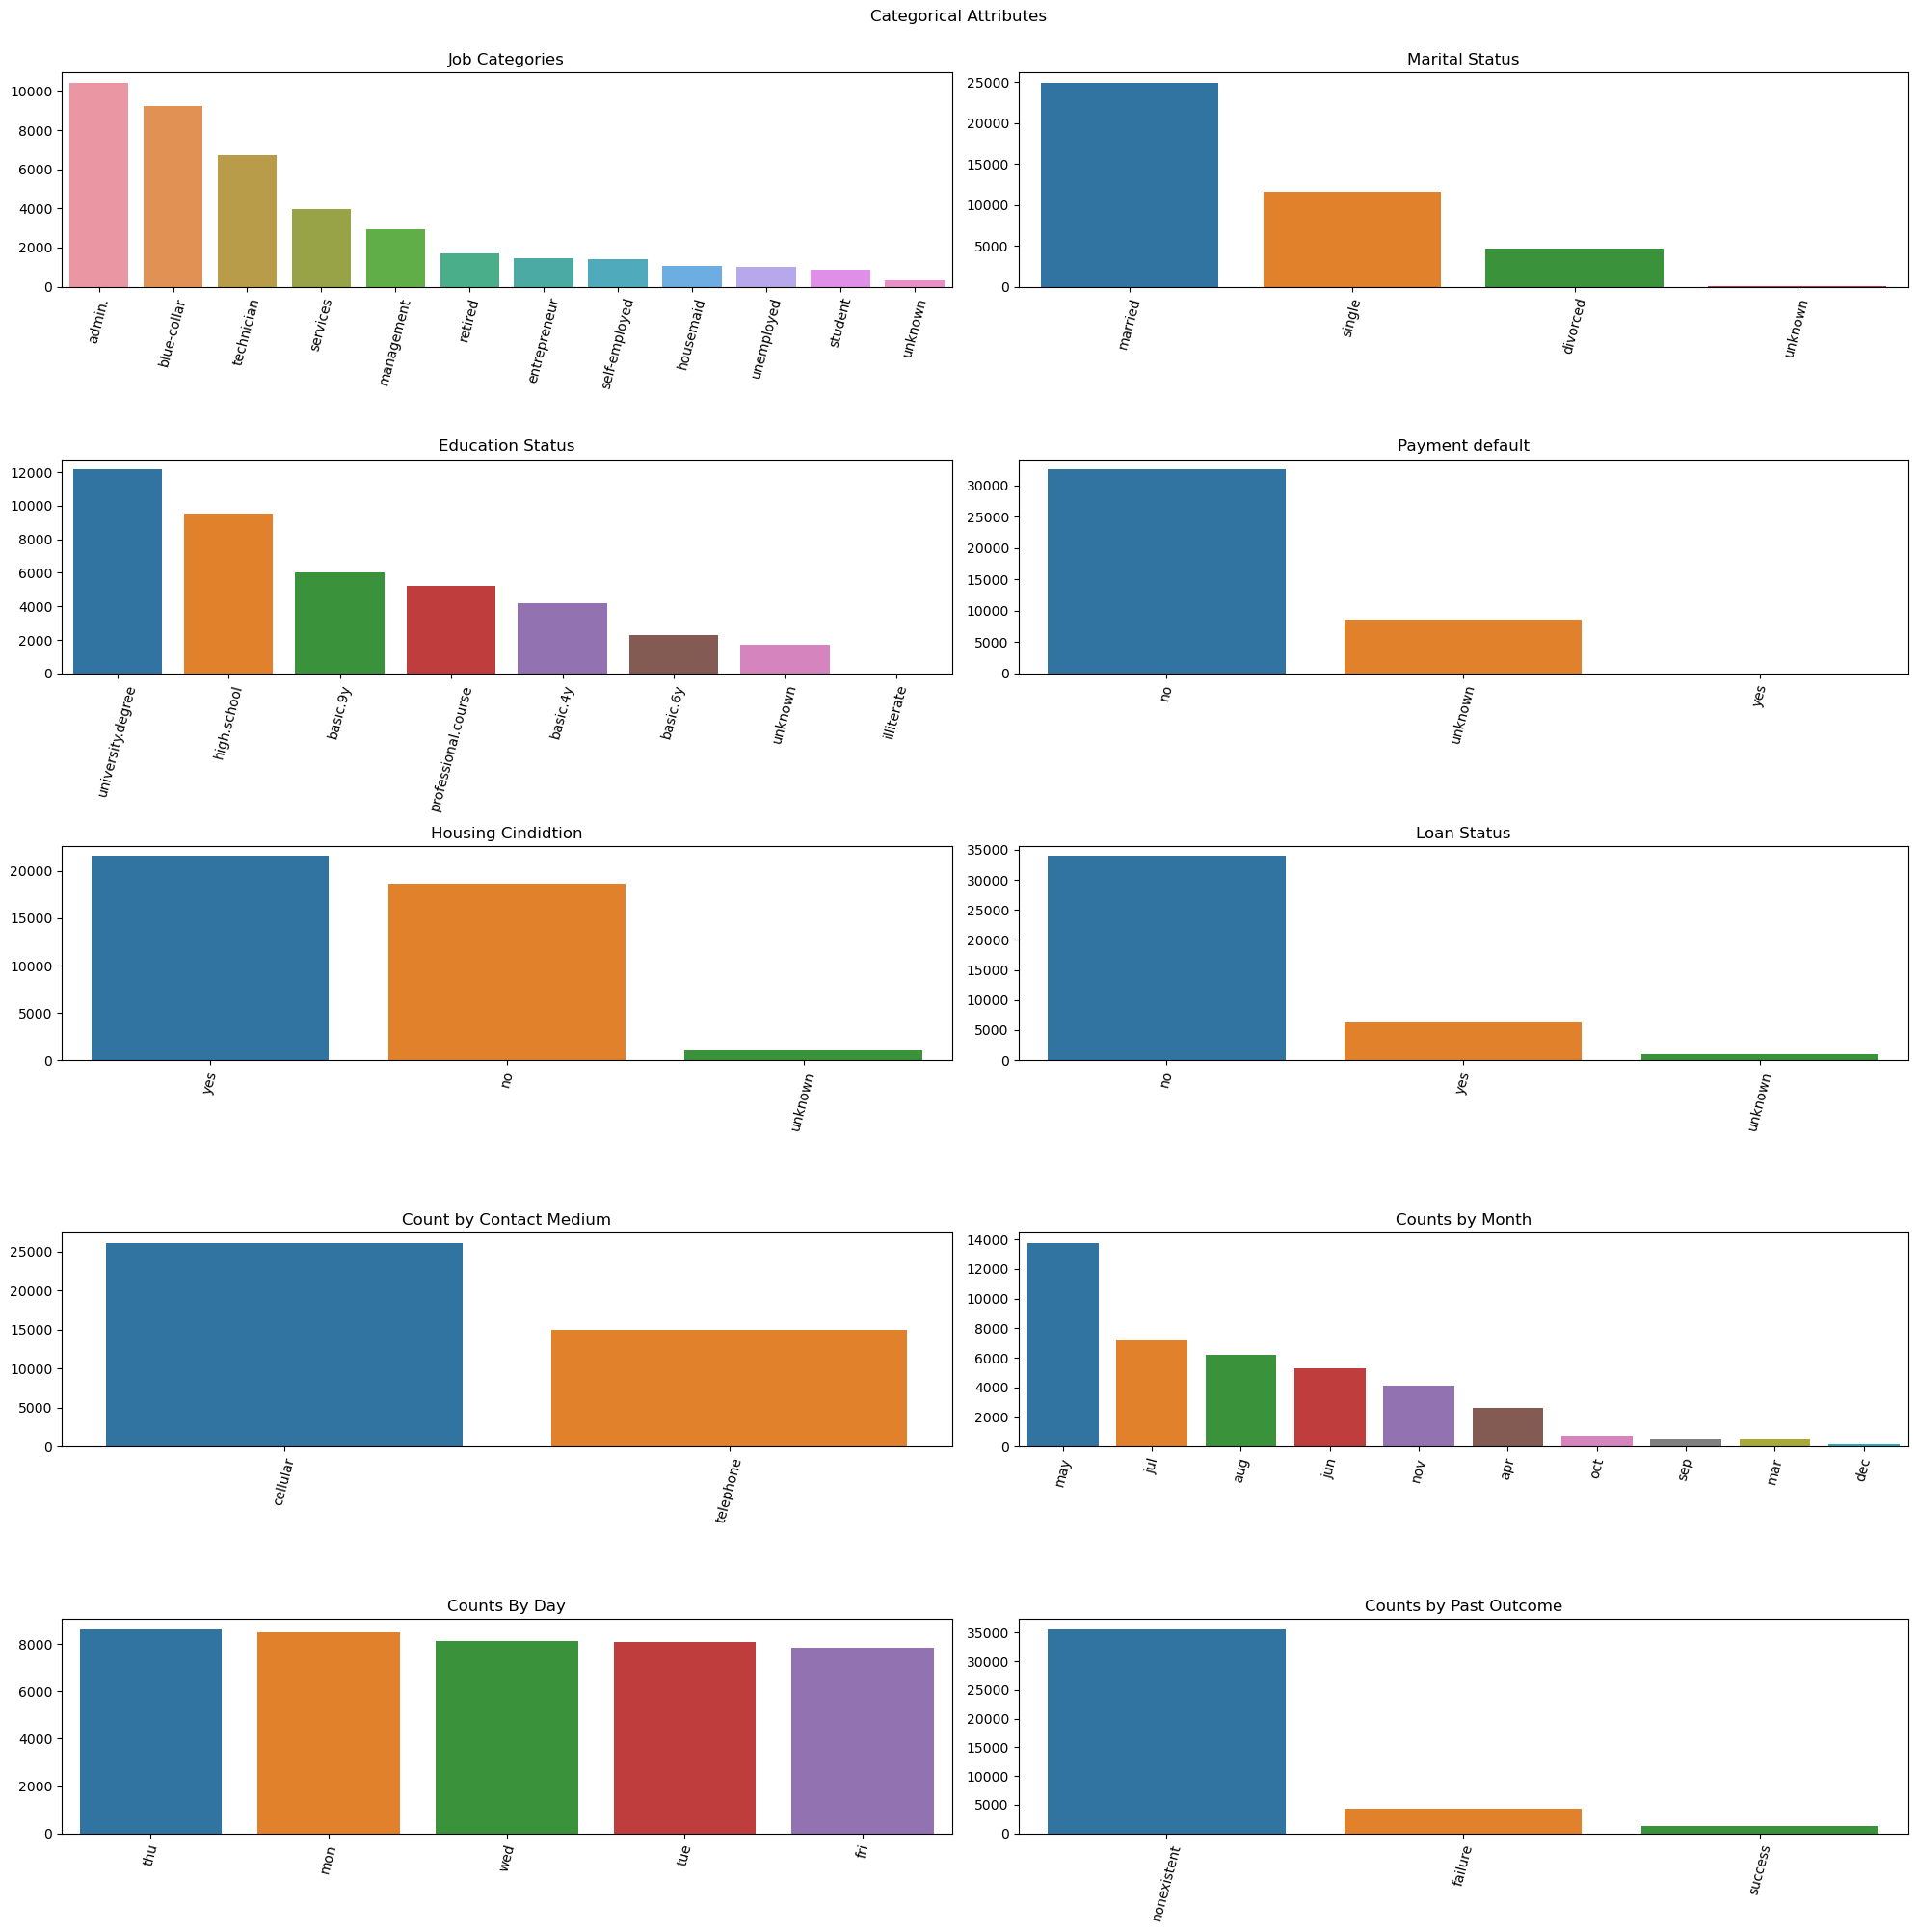

In [15]:
# check categorical values with plots

fig, ax = plt.subplots(5, 2, figsize= (20,20))
fig.suptitle('Categorical Attributes', y=1.)

# create a function for the plots:
def create_plot(attributes, plot_x, plot_y, title):
    plot = sns.countplot(x=attributes, data=df, ax=ax[plot_x, plot_y], order=df[attributes].value_counts().index)
    plot.set_title(title)
    plot.set(xlabel=None, ylabel=None)
    plot.set_xticklabels(plot.get_xticklabels(),rotation = 75)

create_plot('job', 0, 0, 'Job Categories')
create_plot('marital', 0, 1, 'Marital Status')
create_plot('education', 1, 0, 'Education Status')
create_plot('default', 1, 1, 'Payment default')
create_plot('housing', 2, 0, 'Housing Cindidtion')
create_plot('loan', 2, 1, 'Loan Status')
create_plot('contact', 3, 0, 'Count by Contact Medium')
create_plot('month', 3, 1, 'Counts by Month')
create_plot('day_of_week', 4, 0, 'Counts By Day')
create_plot('poutcome', 4, 1, 'Counts by Past Outcome')

fig.tight_layout()
plt.show()

In [16]:
# Unique value of 10 non-object attributes
df.select_dtypes(exclude='object').nunique()

age                 78
duration          1544
campaign            42
pdays               27
previous             8
emp.var.rate        10
cons.price.idx      26
cons.conf.idx       26
euribor3m          316
nr.employed         11
dtype: int64

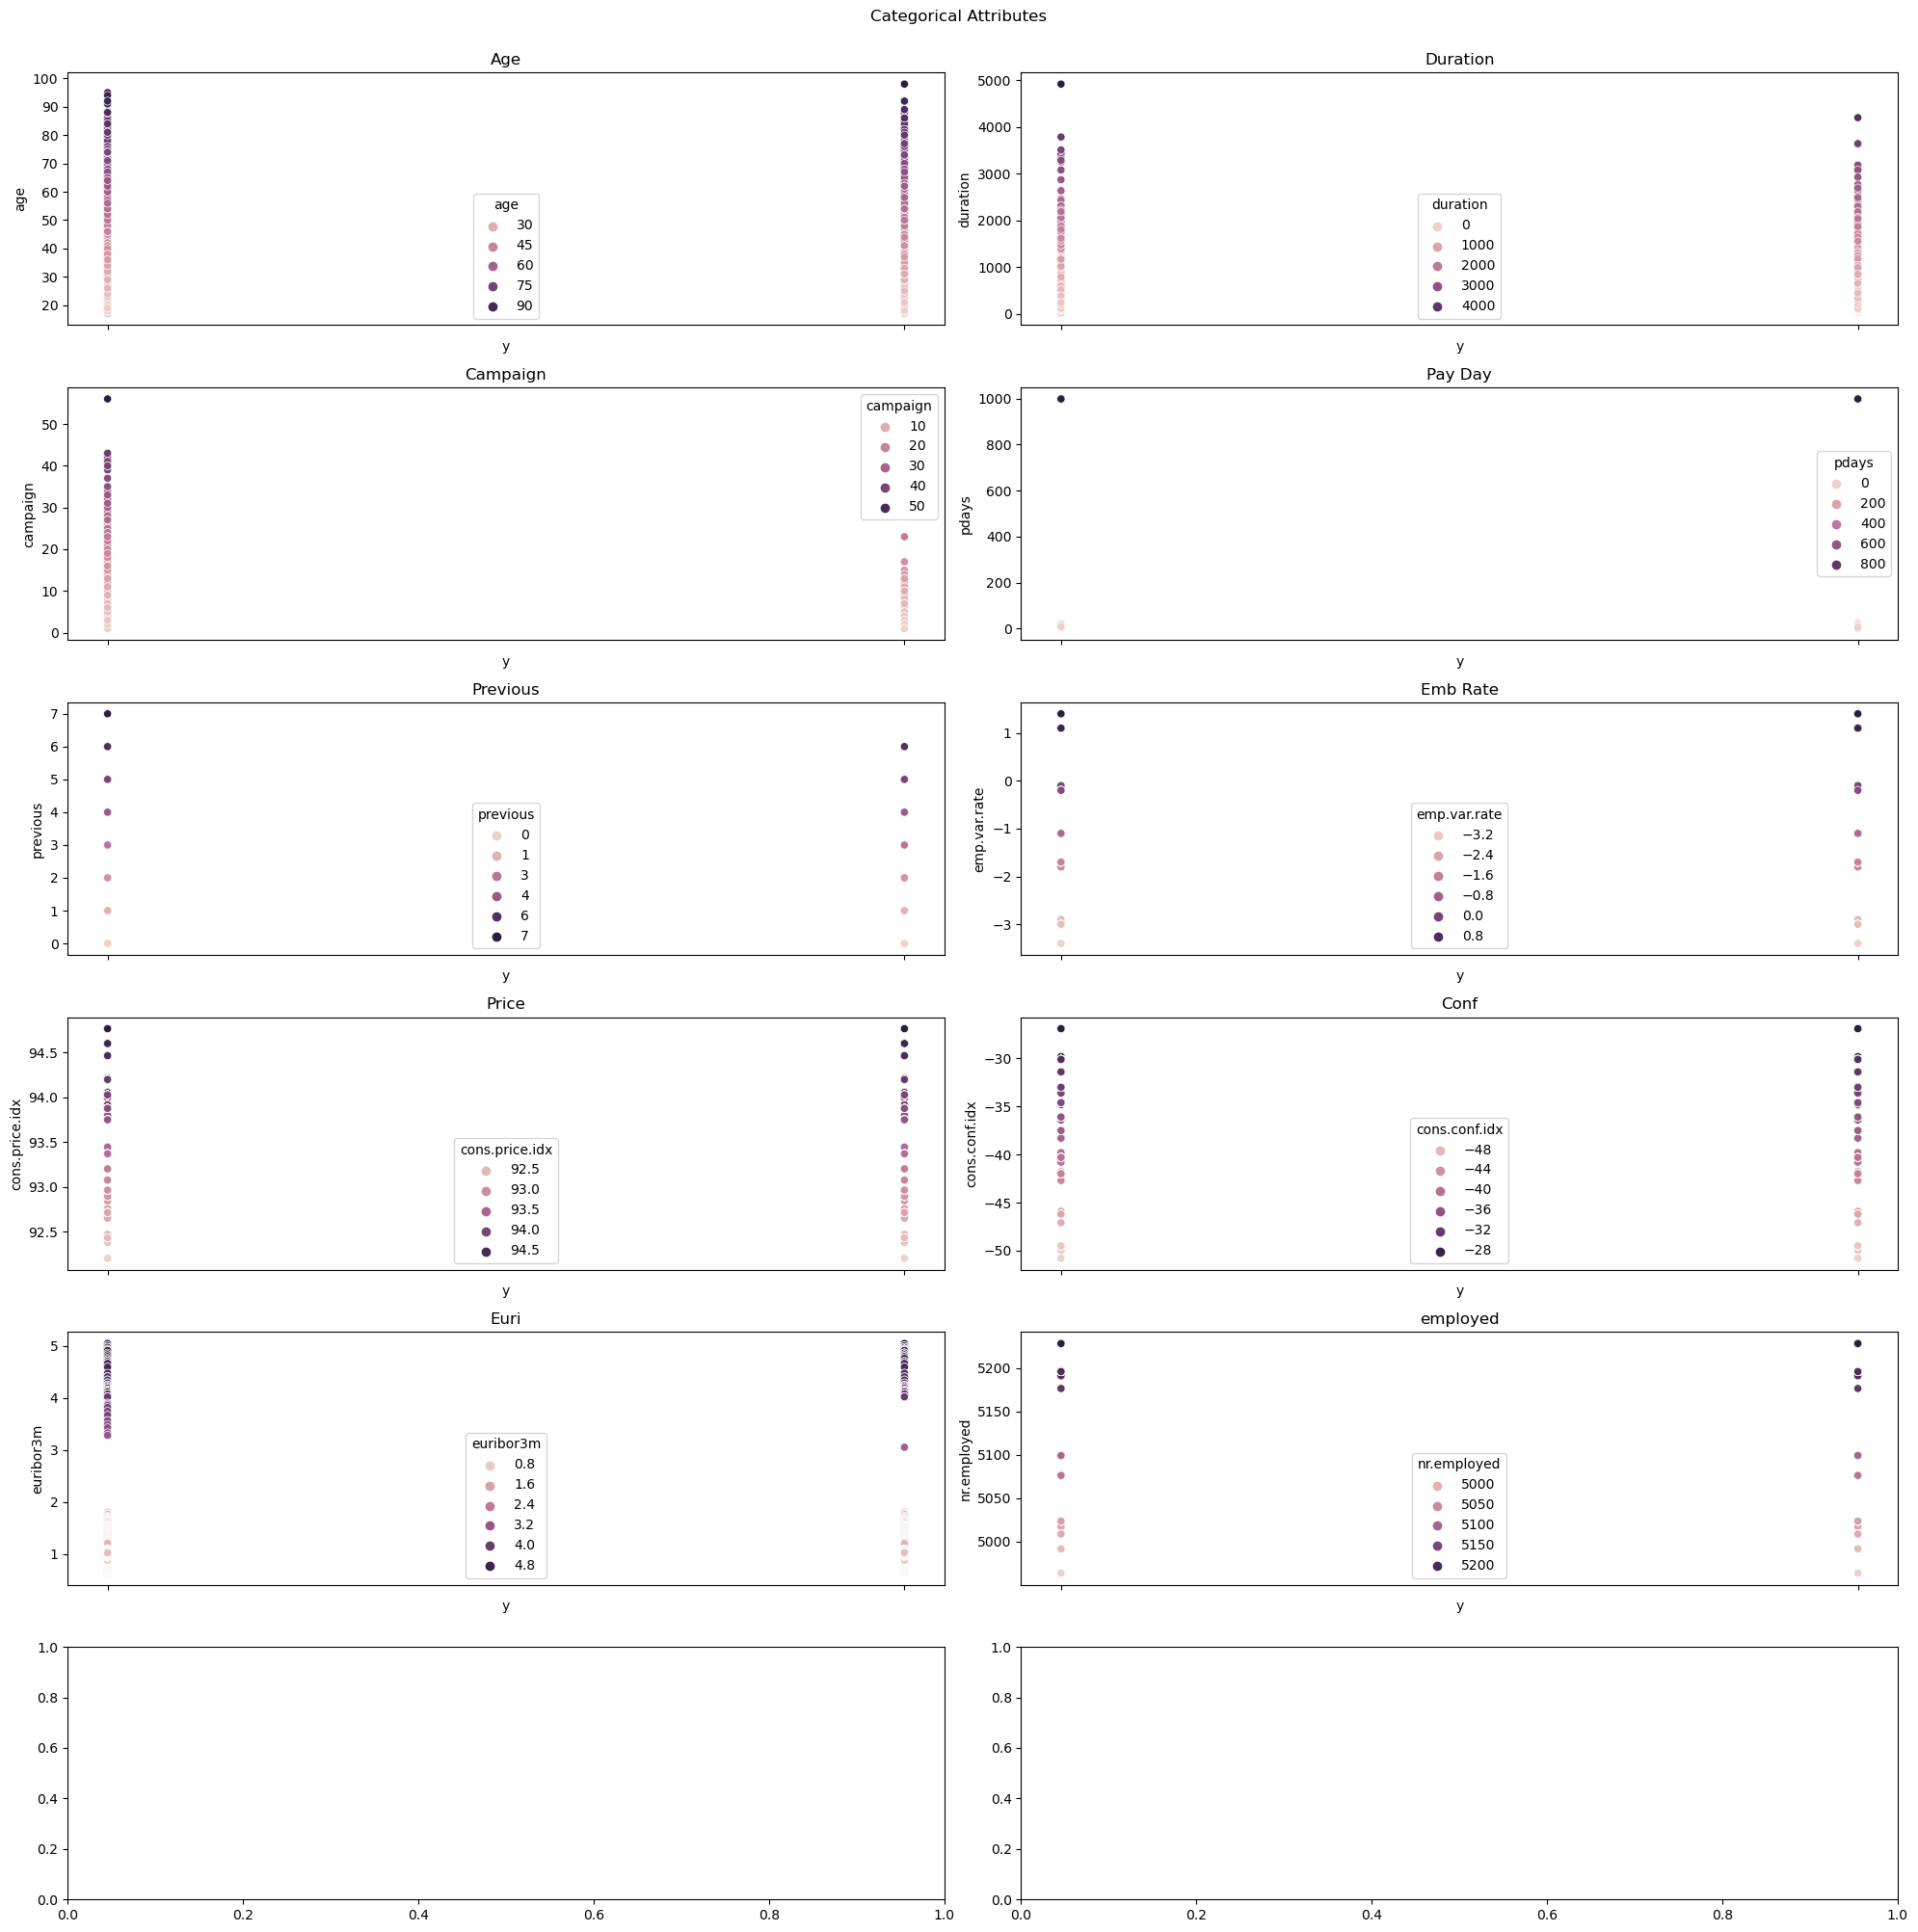

In [17]:
# scattered plot for numeric attributes
fig, ax = plt.subplots(6, 2, figsize= (20,20))
fig.suptitle('Categorical Attributes', y=1.)

def create_scatterplot(x_attribute, y_attribute, plot_x, plot_y, title):
    plot = sns.scatterplot(x=x_attribute, y=y_attribute, data=df, ax=ax[plot_x, plot_y], hue =y_attribute )
    plot.set_title(title)
    plot.set(xlabel=x_attribute, ylabel=y_attribute)
    plot.set_xticklabels(plot.get_xticklabels(),rotation = 75)
    return plot


create_scatterplot('y', 'age',0, 0, 'Age' )
create_scatterplot('y', 'duration',0, 1, 'Duration' )
create_scatterplot('y', 'campaign',1, 0, 'Campaign' )
create_scatterplot('y', 'pdays',1, 1, 'Pay Day' )
create_scatterplot('y', 'previous',2, 0, 'Previous' )
create_scatterplot('y', 'emp.var.rate',2, 1, 'Emb Rate' )
create_scatterplot('y', 'cons.price.idx',3, 0, 'Price' )
create_scatterplot('y', 'cons.conf.idx',3, 1, 'Conf' )
create_scatterplot('y', 'euribor3m',4, 0, 'Euri' )
create_scatterplot('y', 'nr.employed',4, 1, 'employed' )

fig.tight_layout()
plt.show()

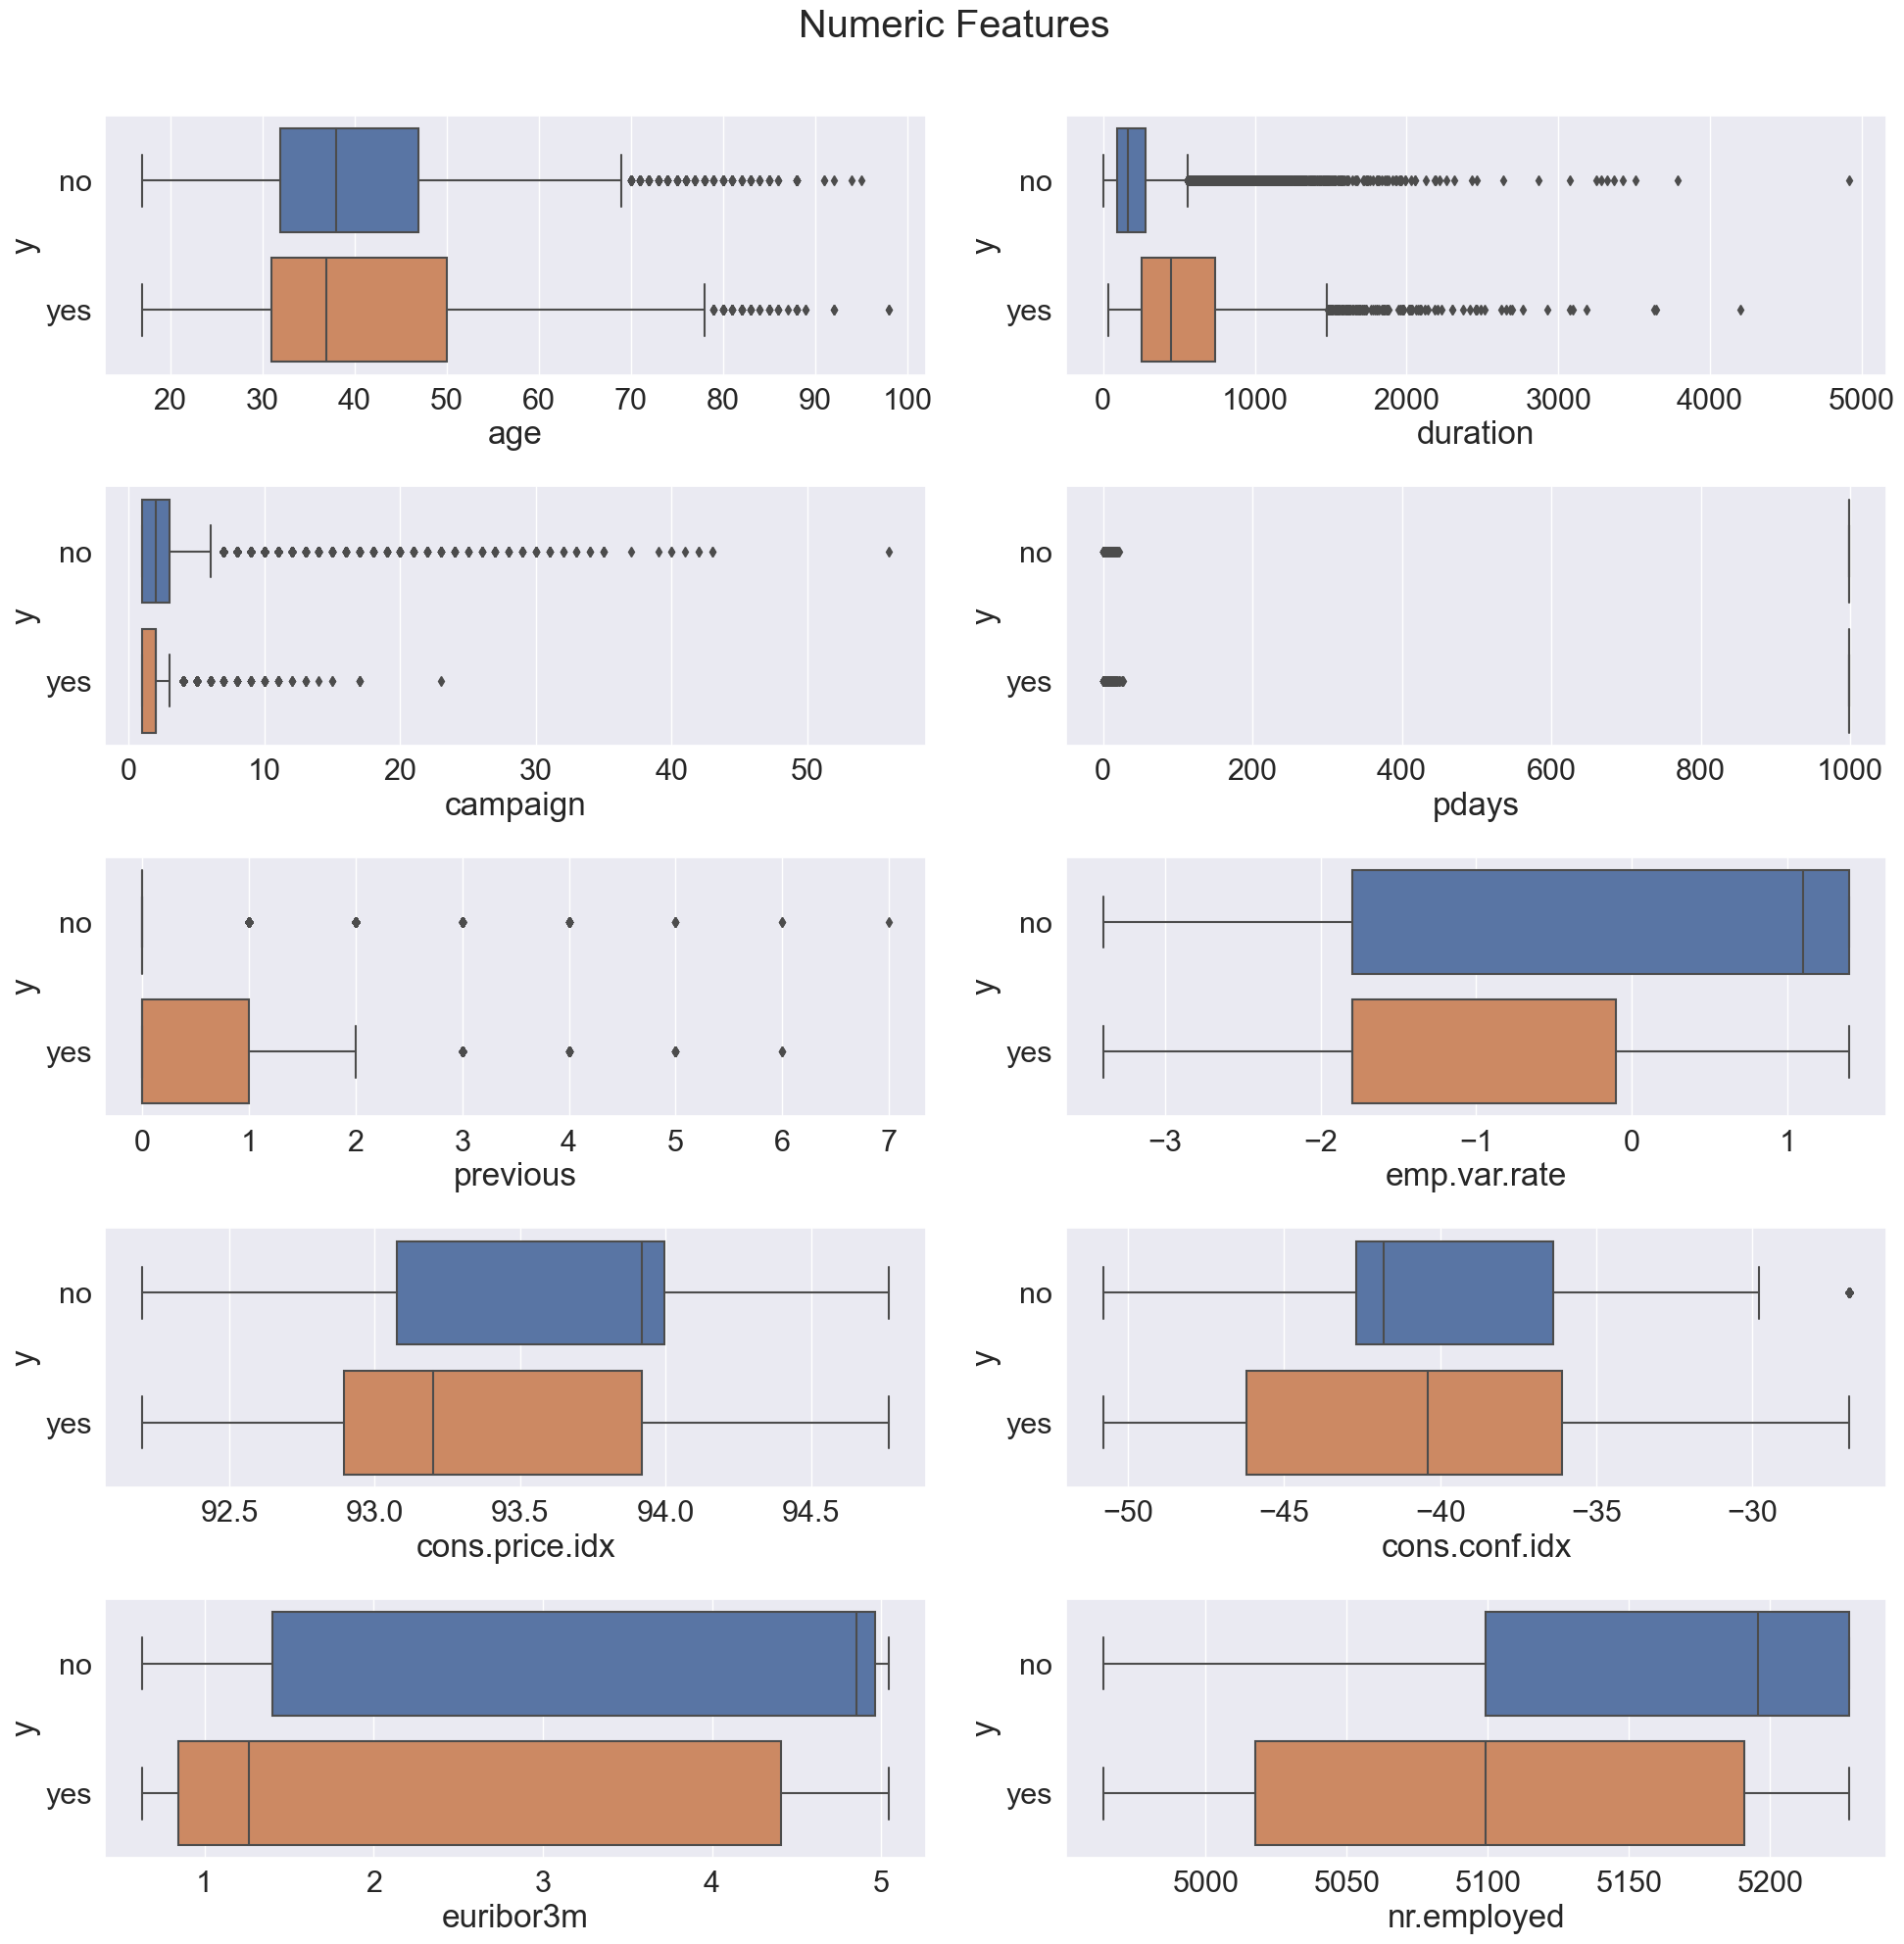

In [18]:
# As scattered plot was not efficient to show the details, using Box plots for numeric features
sns.set(font_scale = 2)

fig, ax = plt.subplots(5, 2, figsize=(20,20))
fig.suptitle('Numeric Features', y=1.)


sns.boxplot(x=df['age'], y=df['y'], ax=ax[0,0])
sns.boxplot(x=df['duration'], y=df['y'], ax=ax[0,1])
sns.boxplot(x=df['campaign'], y=df['y'], ax=ax[1,0])
sns.boxplot(x=df['pdays'], y=df['y'], ax=ax[1,1])
sns.boxplot(x=df['previous'], y=df['y'], ax=ax[2,0])
sns.boxplot(x=df['emp.var.rate'], y=df['y'], ax=ax[2,1])
sns.boxplot(x=df['cons.price.idx'], y=df['y'], ax=ax[3,0])
sns.boxplot(x=df['cons.conf.idx'], y=df['y'], ax=ax[3,1])
sns.boxplot(x=df['euribor3m'], y=df['y'], ax=ax[4,0])
sns.boxplot(x=df['nr.employed'], y=df['y'], ax=ax[4,1])

fig.tight_layout()
plt.show()

In [19]:
# reching the unique value of 11 categorical attributes and then convert them to the numeric values
df.select_dtypes("object").nunique()

job            12
marital         4
education       8
default         3
housing         3
loan            3
contact         2
month          10
day_of_week     5
poutcome        3
y               2
dtype: int64

In [20]:
# map Marital status
df['marital'] = df['marital'].map({'married':4, 'single':3, 'divorced':2, 'unknown':0})

# Map Education 
df['education'] = df['education'].map({'basic.4y':2,'basic.6y':3,'basic.9y':4,'high.school':5,'illiterate':1,
                                           'professional.course':6,'university.degree':7,'unknown':0})
# default, housing, loan 
map_value = {'no':1,'yes':2,'unknown':0}
df['default'] = df['default'].map(map_value)
df['housing'] = df['housing'].map(map_value)
df['loan'] = df['loan'].map(map_value)

# map contacts
df['contact'] = df['contact'].map({'cellular':1,'telephone':0})

# Map months
df['month'] = df['month'].map({'jan': 0, 'feb': 1, 'mar': 2, 'apr': 3, 'may': 4, 'jun': 5, 'jul': 6, 'aug': 7, 'sep': 8, 'oct': 9, 'nov': 10, 'dec': 11})

# map days of the week
df['day_of_week'] = df['day_of_week'].map({'mon':1, 'tue':2, 'wed':3, 'thu':4, 'fri':5})


# map poutcome
df['poutcome'] = df['poutcome'].map({'failure':1,'nonexistent':0,'success':2})

# Map target term deposit column yes/no to 1/0
df['y'] = df['y'].map({'yes':1, 'no':0})

# factorization - Factorization is a technique used for encoding categorical variables, where each unique category is replaced with a unique integer value. 
df['job'] = df['job'].factorize()[0]



In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41176 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41176 non-null  int64  
 1   job             41176 non-null  int64  
 2   marital         41176 non-null  int64  
 3   education       41176 non-null  int64  
 4   default         41176 non-null  int64  
 5   housing         41176 non-null  int64  
 6   loan            41176 non-null  int64  
 7   contact         41176 non-null  int64  
 8   month           41176 non-null  int64  
 9   day_of_week     41176 non-null  int64  
 10  duration        41176 non-null  int64  
 11  campaign        41176 non-null  int64  
 12  pdays           41176 non-null  int64  
 13  previous        41176 non-null  int64  
 14  poutcome        41176 non-null  int64  
 15  emp.var.rate    41176 non-null  float64
 16  cons.price.idx  41176 non-null  float64
 17  cons.conf.idx   41176 non-null 

In [22]:
df.tail()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
41183,73,5,4,6,1,2,1,1,10,5,...,1,999,0,0,-1.1,94.767,-50.8,1.028,4963.6,1
41184,46,3,4,6,1,1,1,1,10,5,...,1,999,0,0,-1.1,94.767,-50.8,1.028,4963.6,0
41185,56,5,4,7,1,2,1,1,10,5,...,2,999,0,0,-1.1,94.767,-50.8,1.028,4963.6,0
41186,44,4,4,6,1,1,1,1,10,5,...,1,999,0,0,-1.1,94.767,-50.8,1.028,4963.6,1
41187,74,5,4,6,1,2,1,1,10,5,...,3,999,1,1,-1.1,94.767,-50.8,1.028,4963.6,0


In [23]:
df.describe()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
count,41176.00000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,...,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000
mean,40.02380,3.673863,3.487420,4.943924,0.791310,1.499830,1.127696,0.634714,5.607733,2.979600,...,2.567879,962.464810,0.173013,0.169953,0.081922,93.575720,-40.502863,3.621293,5167.034870,0.112663
std,10.42068,2.454340,0.705077,1.909281,0.406556,0.545979,0.399349,0.481516,2.041013,1.411539,...,2.770318,186.937102,0.494964,0.455811,1.570883,0.578839,4.627860,1.734437,72.251364,0.316184
min,17.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,...,1.000000,0.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000
25%,32.00000,2.000000,3.000000,4.000000,1.000000,1.000000,1.000000,0.000000,4.000000,2.000000,...,1.000000,999.000000,0.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000,0.000000
50%,38.00000,3.000000,4.000000,5.000000,1.000000,2.000000,1.000000,1.000000,5.000000,3.000000,...,2.000000,999.000000,0.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000,0.000000
75%,47.00000,4.000000,4.000000,7.000000,1.000000,2.000000,1.000000,1.000000,7.000000,4.000000,...,3.000000,999.000000,0.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,0.000000
max,98.00000,11.000000,4.000000,7.000000,2.000000,2.000000,2.000000,1.000000,11.000000,5.000000,...,56.000000,999.000000,7.000000,2.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,1.000000


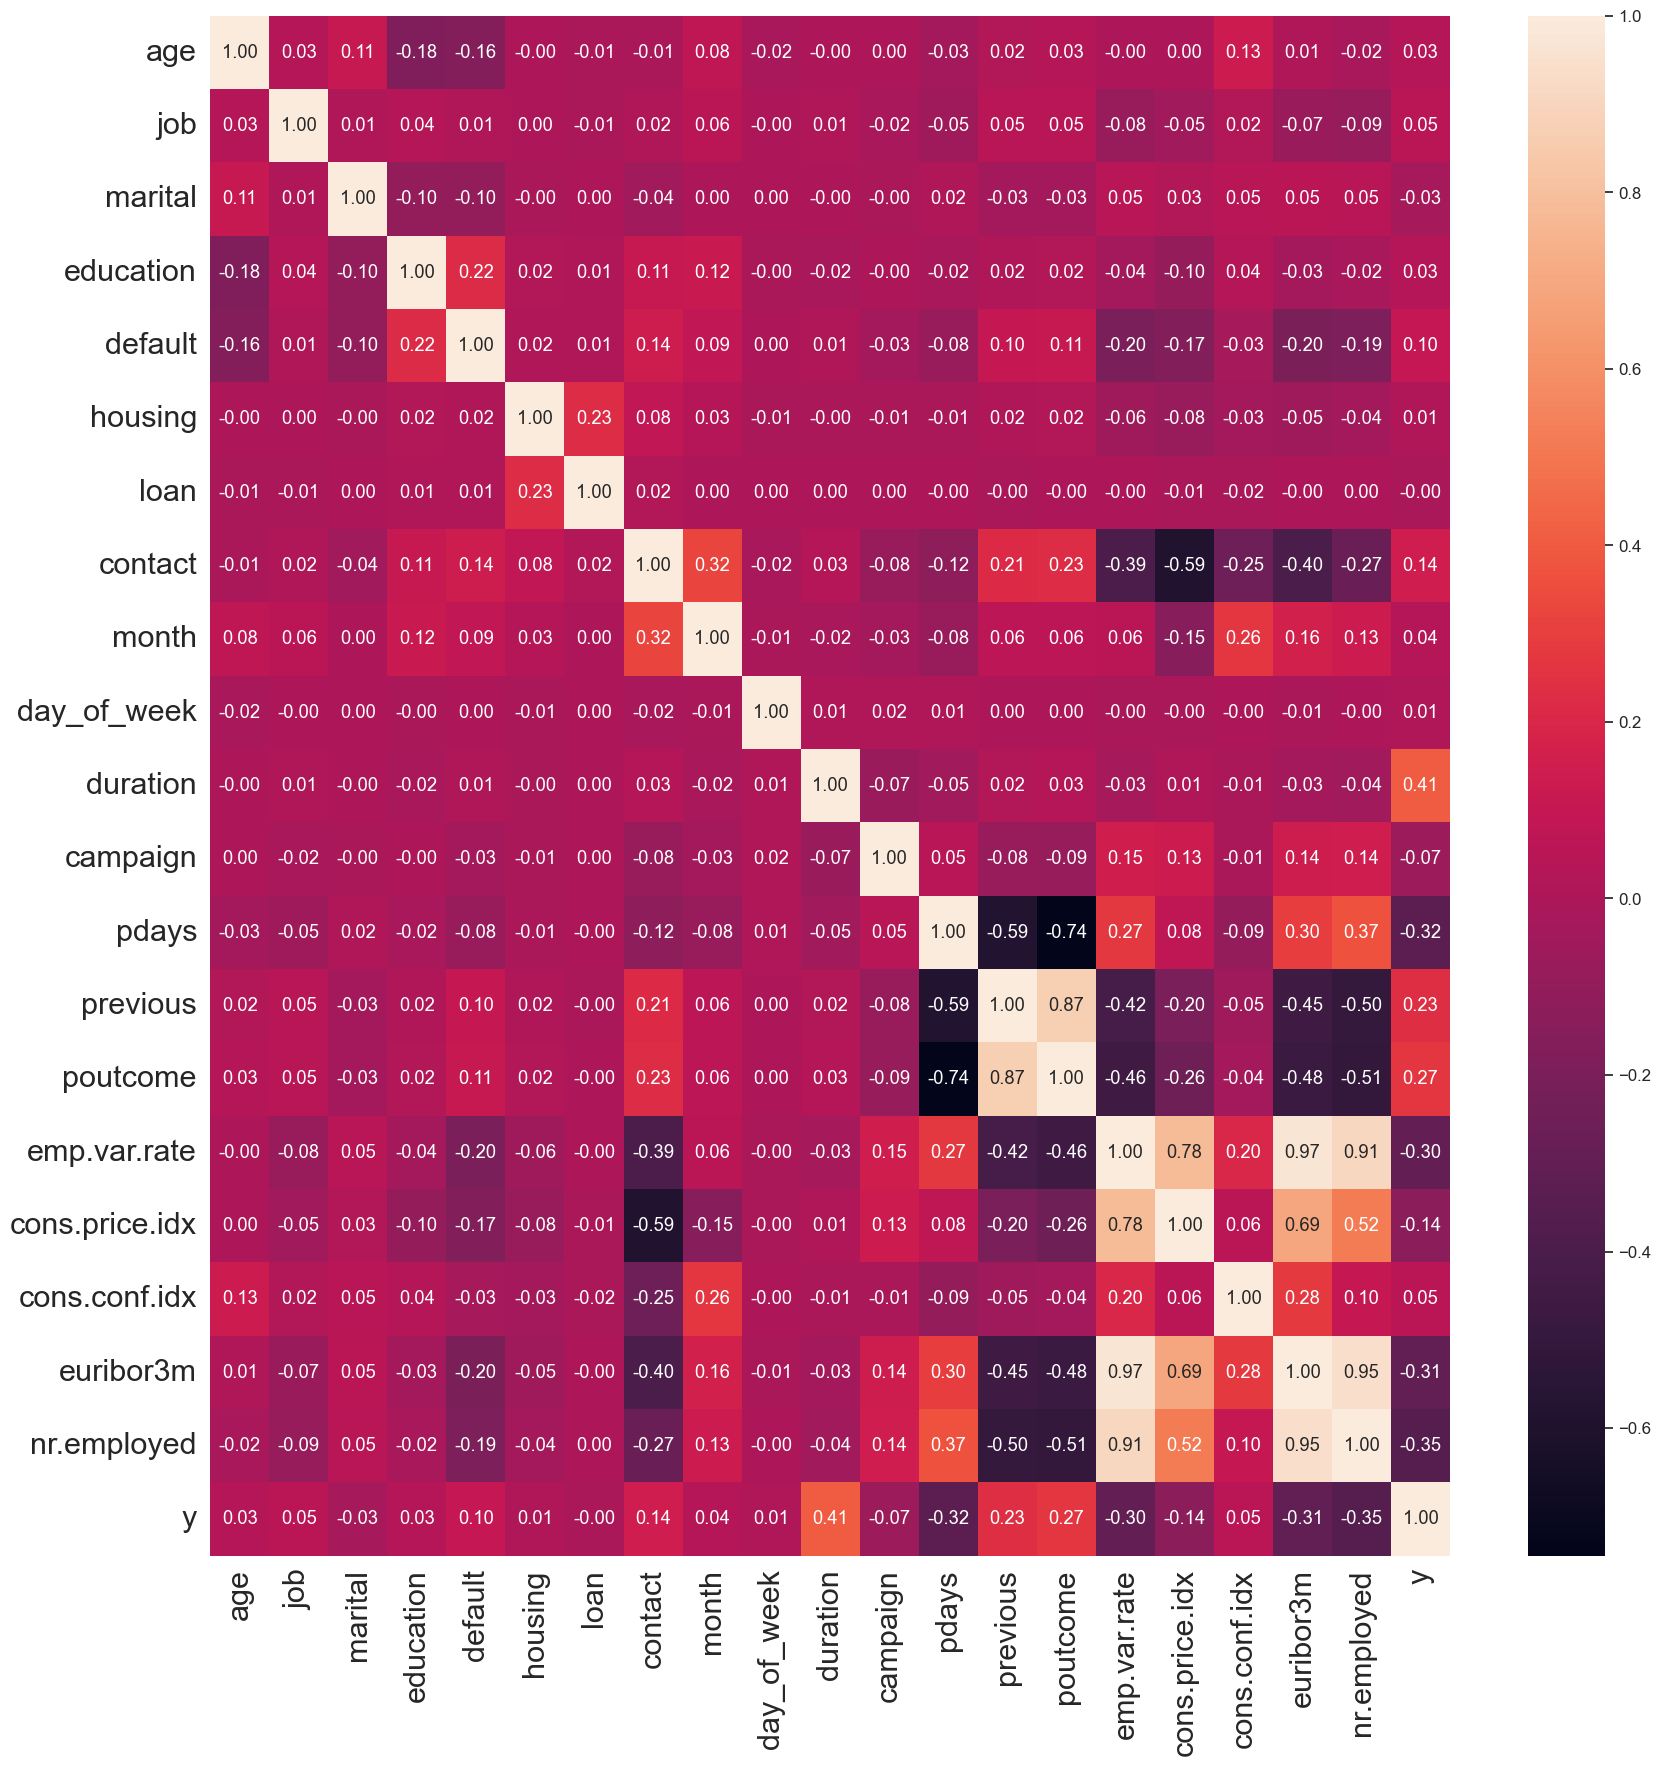

In [24]:
#heatmap
plt.subplots(figsize=(20,20))
sns.set(font_scale=1.1)
sns.heatmap(df.corr(), annot=True, fmt='.2f')
plt.show()


### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

### Business Objective:
The task is to build a model that can predict whether a client will subscribe to a term deposit based on certain features, while also determining which features have the greatest influence on their decision. This will aid in identifying the key factors that impact success, allowing for more efficient use of resources (such as human effort, phone calls, and time) and the selection of potential customers who are both high quality and affordable.

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41176 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41176 non-null  int64  
 1   job             41176 non-null  int64  
 2   marital         41176 non-null  int64  
 3   education       41176 non-null  int64  
 4   default         41176 non-null  int64  
 5   housing         41176 non-null  int64  
 6   loan            41176 non-null  int64  
 7   contact         41176 non-null  int64  
 8   month           41176 non-null  int64  
 9   day_of_week     41176 non-null  int64  
 10  duration        41176 non-null  int64  
 11  campaign        41176 non-null  int64  
 12  pdays           41176 non-null  int64  
 13  previous        41176 non-null  int64  
 14  poutcome        41176 non-null  int64  
 15  emp.var.rate    41176 non-null  float64
 16  cons.price.idx  41176 non-null  float64
 17  cons.conf.idx   41176 non-null 

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features (columns 1 - 7), prepare the features and target column for modeling with appropriate encoding and transformations.

In [26]:
# data transformation was done in above section, leveraging the same for building the basic model
X, y = df.iloc[:, 0:7], df.y

X.shape, y.shape

((41176, 7), (41176,))

In [27]:
X

,age,job,marital,education,default,housing,loan
0,56,0,4,2,1,1,1
1,57,1,4,5,0,1,1
2,37,1,4,5,1,2,1
3,40,2,4,3,1,1,1
4,56,1,4,5,1,1,2
...,...,...,...,...,...,...,...
41183,73,5,4,6,1,2,1
41184,46,3,4,6,1,1,1
41185,56,5,4,7,1,2,1
41186,44,4,4,6,1,1,1


### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2, stratify = y)

<AxesSubplot:>

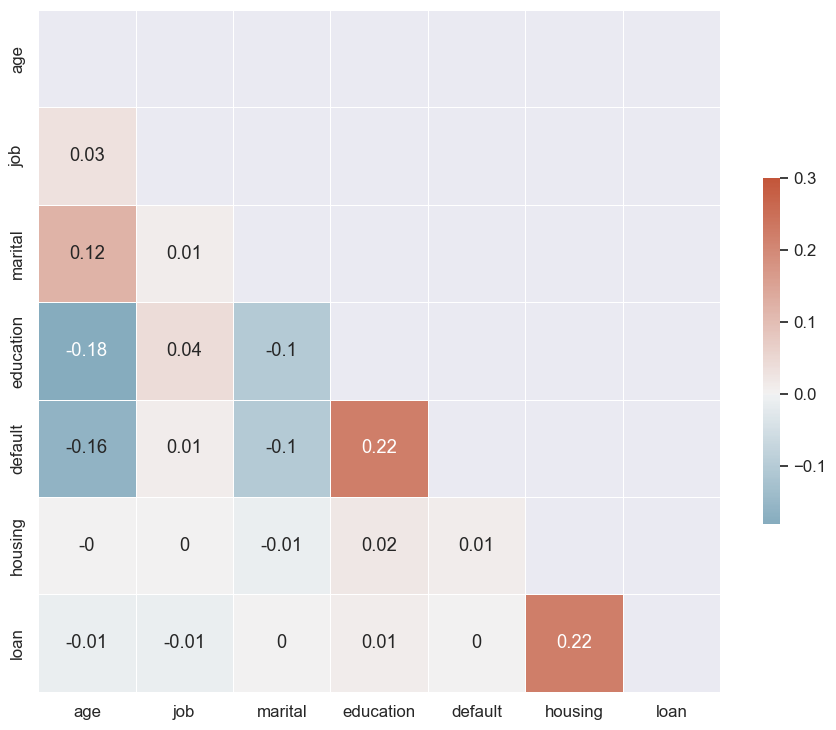

In [29]:
# check correlation matrix to drop correalted features to avoid multi-collinearity. 

# Compute the correlation matrix
corr = np.around(X_train.corr(),2)
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


In [30]:
# There is little to no correlation between the input features which is great for classifiers 
# like Logistic Regression. The next step is scaling of features using StandardScaler

#Scale
X_train=StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

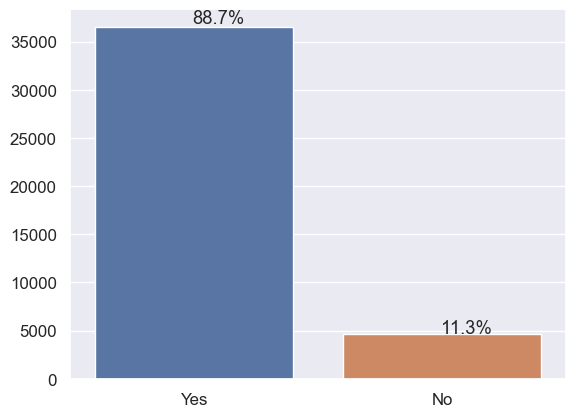

In [31]:
# Baseline - Baseline would be the existing percentage from the sample

plot = sns.countplot(x='y', data=df);
plot.set(xlabel=None, ylabel=None)
plot.set_xticklabels(['Yes', 'No'])
for p in plot.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/len(df))
    x = p.get_x() + 0.5
    y = p.get_height() + p.get_height() * 0.01
    plot.annotate(percentage, (x, y),ha='center')

plt.show()

In [32]:
### this is highly imbalance data, need to use SMOTE to address imbalance through minority oversampling
from imblearn.over_sampling import SMOTE

smt = SMOTE(random_state = 2)
X_train_smt, y_train_smt = smt.fit_resample(X_train, y_train.ravel())

In [33]:
# create a function to execute all the models for basline 
import time

def base_model(base_model):
    start=time.time()
    fit_model = base_model.fit(X_train_smt, y_train_smt)
    end=time.time()
    total_time = end - start
    # score with training set
    accuracy = accuracy_score(y_train_smt, fit_model.predict(X_train_smt))
    fscore = f1_score(y_train_smt, fit_model.predict(X_train_smt))
    recall = recall_score(y_train_smt, fit_model.predict(X_train_smt))

    
    #score with target set
    accuracy_tst = accuracy_score(y_test, fit_model.predict(X_test))
    fscore_tst = f1_score(y_test, fit_model.predict(X_test))
    recall_tst = recall_score(y_test, fit_model.predict(X_test))
    
    
    #print values
    print(f'=======Model = {base_model}========\n')
    print(f'Total Time: {total_time: .5f}\n')
    print(f'====Training Score=====')
    print(f' Accuracy: {accuracy: .5f}')
    print(f'F1 Score: {fscore: .5f}')
    print(f'Recall: {recall: .5f}\n')


    print(f'===Test Score ====')
    print(f'Accuracy: {accuracy_tst: .5f}')
    print(f'F1 Score: {fscore_tst: .5f}')
    print(f'Recall: {recall_tst: .5f}\n')
    
    print('Classification Report\n')
    print(classification_report(y_test, fit_model.predict(X_test)))
    
    # print Confusion matrix 
    plot_confusion_matrix(estimator=fit_model, X=X_test, y_true=y_test,normalize='true', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()

    return base_model, accuracy, fscore, recall, total_time
    

=======Model = DummyClassifier(random_state=42)========

Total Time:  0.00498

====Training Score=====
 Accuracy:  0.50000
F1 Score:  0.00000
Recall:  0.00000

===Test Score ====
Accuracy:  0.88732
F1 Score:  0.00000
Recall:  0.00000

Classification Report

              precision    recall  f1-score   support

           0       0.89      1.00      0.94      7308
           1       0.00      0.00      0.00       928

    accuracy                           0.89      8236
   macro avg       0.44      0.50      0.47      8236
weighted avg       0.79      0.89      0.83      8236



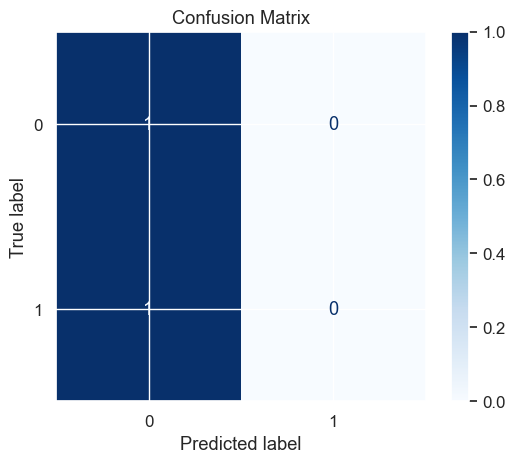

CPU times: user 233 ms, sys: 10 ms, total: 243 ms
Wall time: 242 ms


In [34]:
%%time
# baseline with dummy classifier

dummy = DummyClassifier(random_state=42) 

dummy_model, dummy_acc, dummy_f1, dummy_rec, dummy_time = base_model(dummy)



### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

=======Model = LogisticRegression(max_iter=1000, random_state=0)========

Total Time:  0.05257

====Training Score=====
 Accuracy:  0.56579
F1 Score:  0.60259
Recall:  0.65839

===Test Score ====
Accuracy:  0.49769
F1 Score:  0.23573
Recall:  0.68750

Classification Report

              precision    recall  f1-score   support

           0       0.92      0.47      0.63      7308
           1       0.14      0.69      0.24       928

    accuracy                           0.50      8236
   macro avg       0.53      0.58      0.43      8236
weighted avg       0.83      0.50      0.58      8236



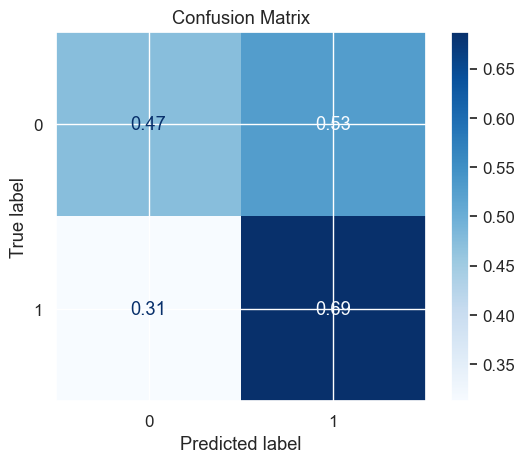

CPU times: user 1.2 s, sys: 78.1 ms, total: 1.27 s
Wall time: 366 ms


In [35]:
%%time
# Logistic Regression
lgr = LogisticRegression(max_iter=1000, random_state=0)

lgr_model, lgr_acc, lgr_f1, lgr_rec, lgr_time = base_model(lgr)

### Problem 9: Score the Model

What is the accuracy of your model?

In [36]:
print(lgr_acc)

0.5657908241814636


=======Model = KNeighborsClassifier()========

Total Time:  0.04401

====Training Score=====
 Accuracy:  0.78981
F1 Score:  0.76033
Recall:  0.66680

===Test Score ====
Accuracy:  0.63575
F1 Score:  0.24089
Recall:  0.51293

Classification Report

              precision    recall  f1-score   support

           0       0.91      0.65      0.76      7308
           1       0.16      0.51      0.24       928

    accuracy                           0.64      8236
   macro avg       0.54      0.58      0.50      8236
weighted avg       0.83      0.64      0.70      8236



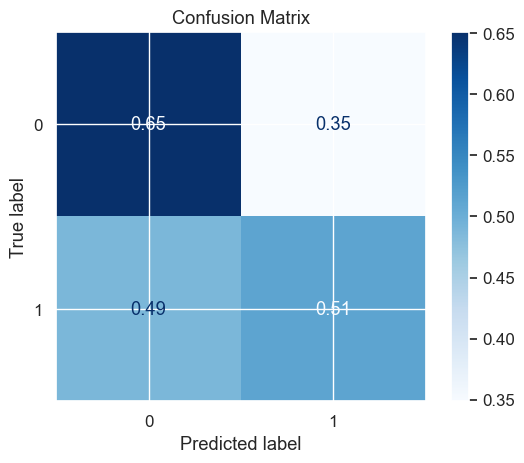

CPU times: user 14.1 s, sys: 64.4 ms, total: 14.2 s
Wall time: 14.2 s


In [37]:
%%time
# KNN Model
knn = KNeighborsClassifier()

knn_model, knn_acc, knn_f1, knn_rec, knn_time = base_model(knn)

=======Model = DecisionTreeClassifier(random_state=0)========

Total Time:  0.18855

====Training Score=====
 Accuracy:  0.90145
F1 Score:  0.90063
Recall:  0.89315

===Test Score ====
Accuracy:  0.16136
F1 Score:  0.20086
Recall:  0.93534

Classification Report

              precision    recall  f1-score   support

           0       0.88      0.06      0.12      7308
           1       0.11      0.94      0.20       928

    accuracy                           0.16      8236
   macro avg       0.50      0.50      0.16      8236
weighted avg       0.80      0.16      0.13      8236



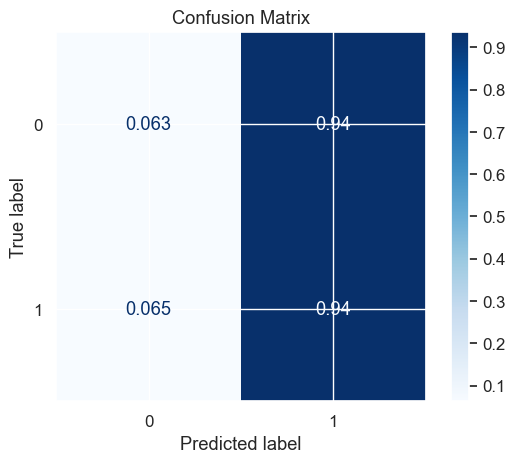

CPU times: user 447 ms, sys: 8.42 ms, total: 455 ms
Wall time: 455 ms


In [38]:
%%time
# Decison tree
dt = DecisionTreeClassifier(random_state=0)
dt_model, dt_acc, dt_f1, dt_rec, dt_time = base_model(dt)


=======Model = SVC ========

Total time:  211.21258

====Training Score=====
 Accuracy:  0.62647
F1 Score:  0.64167
Recall:  0.66889

===Test Score ====
Accuracy:  0.58074
F1 Score:  0.26234
Recall:  0.66164

Classification Report

              precision    recall  f1-score   support

           0       0.93      0.57      0.71      7308
           1       0.16      0.66      0.26       928

    accuracy                           0.58      8236
   macro avg       0.55      0.62      0.48      8236
weighted avg       0.84      0.58      0.66      8236



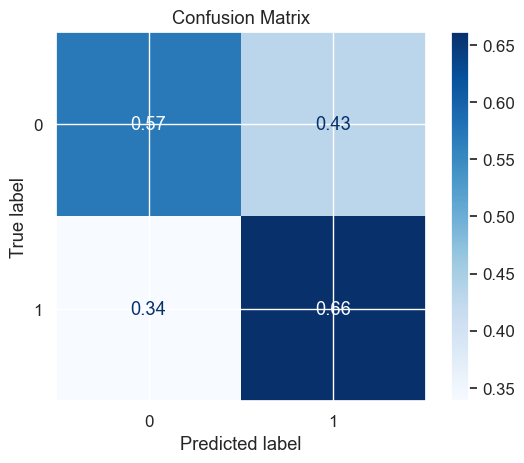

CPU times: user 24min 44s, sys: 1.93 s, total: 24min 46s
Wall time: 24min 47s


In [39]:
%%time
# SVM
from sklearn import preprocessing
start=time.time()
X_train_smt = preprocessing.scale(X_train_smt)
X_test = preprocessing.scale(X_test)

svc = SVC(random_state=0).fit(X_train_smt, y_train_smt)
end=time.time()
total_time = end - start

# score with training set
accuracy_svc = accuracy_score(y_train_smt, svc.predict(X_train_smt))
fscore_svc = f1_score(y_train_smt, svc.predict(X_train_smt))
recall_svc = recall_score(y_train_smt, svc.predict(X_train_smt))

    
#score with target set
accuracy_tst_svc = accuracy_score(y_test, svc.predict(X_test))
fscore_tst_svc = f1_score(y_test, svc.predict(X_test))
recall_tst_svc = recall_score(y_test, svc.predict(X_test))
    
#print values
print(f'=======Model = SVC ========\n')
print(f'Total time: {total_time: .5f}\n')
print(f'====Training Score=====')
print(f' Accuracy: {accuracy_svc: .5f}')
print(f'F1 Score: {fscore_svc: .5f}')
print(f'Recall: {recall_svc: .5f}\n')


print(f'===Test Score ====')
print(f'Accuracy: {accuracy_tst_svc: .5f}')
print(f'F1 Score: {fscore_tst_svc: .5f}')
print(f'Recall: {recall_tst_svc: .5f}\n')
    
print('Classification Report\n')
print(classification_report(y_test, svc.predict(X_test)))
    
# print Confusion matrix 
plot_confusion_matrix(estimator=svc, X=X_test, y_true=y_test,normalize='true', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()



### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [40]:
# Model Comparison:

model_df = pd.DataFrame({'model': ['Dummy', 'Logistic Regression', 'KNN', 'Decision Tree', 'SVM'],
                        'Train Time': [dummy_time, lgr_time, knn_time, dt_time, total_time ],
                        'Train Accuracy':[dummy_acc, lgr_acc, knn_acc, dt_acc, accuracy_svc],
                        'Test Accuracy':[0.88732, 0.49769, 0.63575, 0.16136, 0.58074]})
model_df

,model,Train Time,Train Accuracy,Test Accuracy
0,Dummy,0.004976,0.500000,0.88732
1,Logistic Regression,0.052572,0.565791,0.49769
2,KNN,0.044012,0.789815,0.63575
3,Decision Tree,0.188550,0.901451,0.16136
4,SVM,211.212577,0.626467,0.58074


In [41]:
#### Score of Dummy Classifier is higher than all other mdoels 

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [42]:
# create a function to execute the different models.
#  This function will use GridSearcGridSearchCV for the cross validation and find ot the best hyperparameter
#  

def build_model(model, cv_value, params, score):
    grid = GridSearchCV(model, cv = cv_value, param_grid = params, scoring=score).fit(X_train_smt, y_train_smt)
    tr_score = grid.score(X_train_smt, y_train_smt)
    ts_score = grid.score(X_test, y_test)
    best_param = grid.best_params_
    mean_time = grid.cv_results_['mean_fit_time'].mean()
    preds = grid.predict(X_test)
    accuracy_tst = accuracy_score(y_test, grid.predict(X_test))

    
    
    #print values
    print(f'=======Model = {model}========\n')
    print(f'Training Accuracy: {tr_score: .5f}')
    print(f'Testing Accuracy: {ts_score: .5f}')
    print(f'Best Params for {score}: {best_param}')
    print(f'Mean Time: {mean_time: .5f}\n')
    
#     print('Classification Report\n')
#     print(classification_report(y_test, grid.predict(X_test)))
    
    # print Confusion matrix 
    plot_confusion_matrix(estimator=grid, X=X_test, y_true=y_test,normalize='true')
    plt.title('Confusion Matrix')
    plt.show()

    return grid, tr_score, ts_score, mean_time, best_param

=======Model = LogisticRegression()========

Training Accuracy:  0.83356
Testing Accuracy:  0.88254
Best Params for recall: {'C': 0.001, 'penalty': 'l1', 'solver': 'liblinear'}
Mean Time:  0.02330



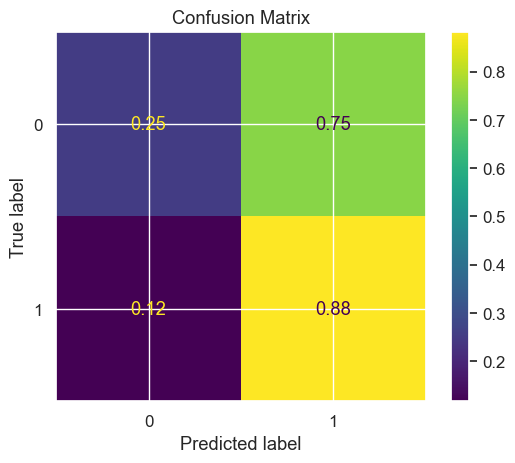

CPU times: user 16.1 s, sys: 411 ms, total: 16.5 s
Wall time: 4.19 s


In [43]:
%%time
# logistic regression
lgr = LogisticRegression()
cv_value = 5
params = {
    'penalty' : ['l1','l2'], 
    'C'       : np.logspace(-3,3,7),
    'solver'  : ['lbfgs', 'liblinear'],
}

score='recall' #data is imbalace hence 'recall' will be used as the scoring metric
# score='accuracy' #data is imbalaced so 'accuracy' is not the correct metric to measure

lgr_grid, lgr_tr_score, lgr_ts_score, lgr_mean_time, lgr_best_param = build_model(lgr, cv_value, params, score)


=======Model = KNeighborsClassifier()========

Training Accuracy:  0.78706
Testing Accuracy:  0.57220
Best Params for recall: {'n_neighbors': 1, 'weights': 'uniform'}
Mean Time:  0.02951



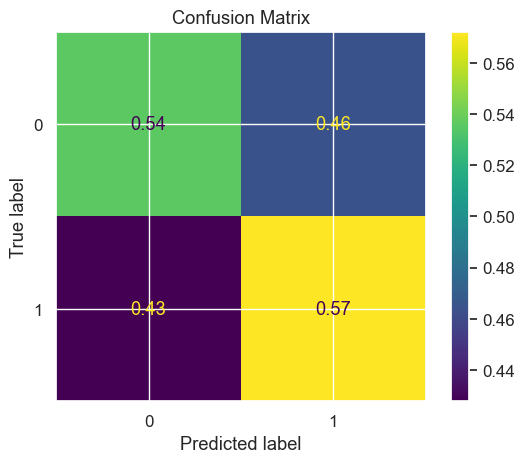

CPU times: user 21.9 s, sys: 50.6 ms, total: 21.9 s
Wall time: 21.9 s


In [44]:
%%time
# KNN classifier
knn = KNeighborsClassifier()

params = {'n_neighbors': [1, 3, 5, 7, 9], 'weights':['uniform']}
cv_value = 5

knn_grid, knn_tr_score, knn_ts_score, knn_mean_time, knn_best_param = build_model(knn, cv_value, params, score)

=======Model = DecisionTreeClassifier()========

Training Accuracy:  0.91180
Testing Accuracy:  1.00000
Best Params for recall: {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}
Mean Time:  0.02089



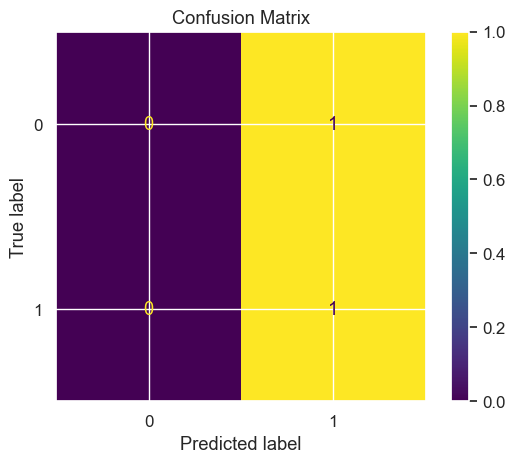

CPU times: user 29.3 s, sys: 393 ms, total: 29.7 s
Wall time: 29.7 s


In [45]:
%%time
# Decision Tree
dtree = DecisionTreeClassifier()
params = {'max_depth': range(1, 11),
          'min_samples_split': [2, 4 , 6],
          'criterion': ['gini', 'entropy'],
          'min_samples_leaf': [0.25, 0.5, 0.75, 1]
         }
cv_value = 5

dtree_grid, dtree_tr_score, dtree_ts_score, dtree_mean_time, dtree_best_param = build_model(dtree, cv_value, params, score)


In [46]:
# %%time
# # SVM
# svm = SVC(cache_size=1000)

# params = {'kernel': ['rbf', 'poly', 'linear', 'sigmoid'],
#           'gamma': [0.1, 1.0, 10.0, 100.0],}
# svm_grid, svm_train, svm_test, svm_time, svm_params, svm_results = build_model(svm, cv_value, params, score)

In [47]:
#  This section of code was taking way longer time, interrupted and cancelled it after 2 hrs of execution 

# params_svc = {'kernel': ['rbf', 'poly', 'linear', 'sigmoid']}

# svm = SVC(random_state = 42, probability=True)

# grid1 = GridSearchCV(svm, param_grid = params_svc, scoring='recall').fit(X_train_smt, y_train_smt)

# # grid = GridSearchCV(model, cv = cv_value, param_grid = params, scoring=score).fit(X_train_smt, y_train_smt)
# tr_score_sv = grid1.score(X_train_smt, y_train_smt)
# ts_score_sv = grid1.score(X_test, y_test)
# best_param_sv = grid1.best_params_
# mean_time_sv = grid1.cv_results_['mean_fit_time'].mean()
# preds_sv = grid1.predict(X_test)
# accuracy_tst_sv = accuracy_score(y_test, grid1.predict(X_test))

# #print values
# print(f'=======Model = SVC ========\n')
# print(f'Training Accuracy: {tr_score_sv: .5f}')
# print(f'Testing Accuracy: {ts_score_sv: .5f}')
# print(f'Best Params for {ts_score_sv}: {best_param_sv}')
# print(f'Mean Time: {mean_time_sv: .5f}\n')    
# plot_confusion_matrix(estimator=grid1, X=X_test, y_true=y_test,normalize='true')
# plt.title('Confusion Matrix')
# plt.show()


=======Model = SVC ========

Training Accuracy:  0.90332
Testing Accuracy:  0.91487
Best Params for 0.9148706896551724: {'kernel': 'linear'}
Mean Time:  1404.54163



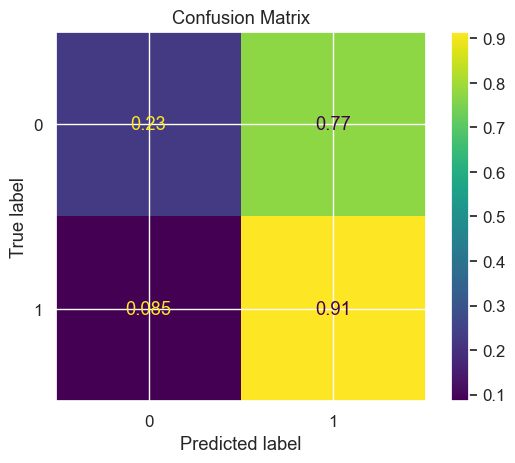

In [50]:
%%time

#  reduce hyper parameters as execution was heavy on computation and was taking longer time. 
# Added parallel processing by using n_jobs
#  => due to long execution time, function is not being used here

params_svc = {'kernel': ['rbf', 'linear']}
svm = SVC(random_state=42, probability=True)
grid1 = GridSearchCV(svm, param_grid=params_svc, scoring='recall', n_jobs=-1).fit(X_train_smt, y_train_smt)

tr_score_sv = grid1.score(X_train_smt, y_train_smt)
ts_score_sv = grid1.score(X_test, y_test)
best_param_sv = grid1.best_params_
mean_time_sv = grid1.cv_results_['mean_fit_time'].mean()
preds_sv = grid1.predict(X_test)
accuracy_tst_sv = accuracy_score(y_test, preds_sv)

#print values
print(f'=======Model = SVC ========\n')
print(f'Training Accuracy: {tr_score_sv: .5f}')
print(f'Testing Accuracy: {ts_score_sv: .5f}')
print(f'Best Params for {ts_score_sv}: {best_param_sv}')
print(f'Mean Time: {mean_time_sv: .5f}\n')    
plot_confusion_matrix(estimator=grid1, X=X_test, y_true=y_test,normalize='true')
plt.title('Confusion Matrix')
plt.show()


Text(0.5, 1.0, 'Comparing ROC curves for different classifiers')

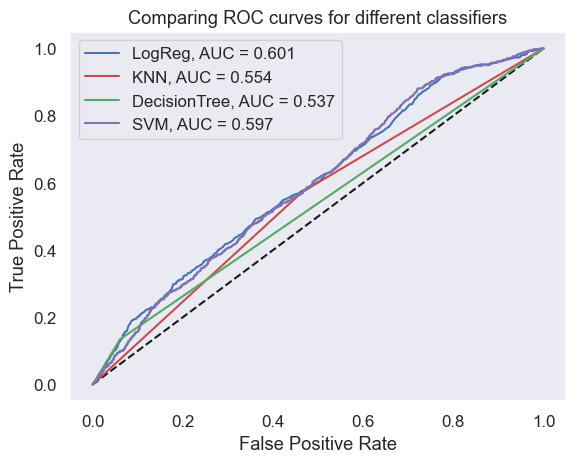

In [57]:
#compare ROC curves for different models

plt.plot([0, 1], [0, 1],'k--')

fpr_logreg, tpr_logreg, thresh_logreg = roc_curve(y_test, lgr_grid.best_estimator_.predict_proba(X_test)[:,1])
fpr_knn, tpr_knn, thresh_knn = roc_curve(y_test, knn_grid.best_estimator_.predict_proba(X_test)[:,1])
fpr_DTC, tpr_DTC, thresh_DTC = roc_curve(y_test, dtree_grid.best_estimator_.predict_proba(X_test)[:,1])
fpr_SVC, tpr_SVC, thresh_SVC = roc_curve(y_test, grid1.best_estimator_.predict_proba(X_test)[:,1])


auclogreg = roc_auc_score(y_test,lgr_grid.best_estimator_.predict_proba(X_test)[:,1] )
aucknn = roc_auc_score(y_test,knn_grid.best_estimator_.predict_proba(X_test)[:,1] )
aucDTC = roc_auc_score(y_test,dtree_grid.best_estimator_.predict_proba(X_test)[:,1] )
aucSVC = roc_auc_score(y_test,grid1.best_estimator_.predict_proba(X_test)[:,1] )


plt.plot(fpr_logreg, tpr_logreg,'b', label=f'LogReg, AUC = {str(round(auclogreg,3))}')
plt.plot(fpr_knn, tpr_knn,'r', label=f'KNN, AUC = {str(round(aucknn,3))}')
plt.plot(fpr_DTC, tpr_DTC,'g', label=f'DecisionTree, AUC = {str(round(aucDTC,3))}')
plt.plot(fpr_SVC, tpr_SVC,'m', label=f'SVM, AUC = {str(round(aucSVC,3))}')



plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.title('Comparing ROC curves for different classifiers')


In [60]:
# summary of results after hyperparameter optimization with GridSearchCV for different models

pd.set_option('max_colwidth', None)

grid_df = {'Models': [ 'Logistic Regression',  'KNeighbors', 'Decision Tree', 'SVC'],
           'Score': [lgr_ts_score, knn_ts_score, dtree_ts_score, ts_score_sv],
            'Best params ':[lgr_best_param,   knn_best_param, dtree_best_param, best_param_sv],
           'Average fit time' : [knn_mean_time,  knn_mean_time, dtree_mean_time, mean_time_sv]      
                   }

grid_df = pd.DataFrame(grid_df)
grid_df



,Models,Score,Best params,Average fit time
0,Logistic Regression,0.882543,"{'C': 0.001, 'penalty': 'l1', 'solver': 'liblinear'}",0.029507
1,KNeighbors,0.572198,"{'n_neighbors': 1, 'weights': 'uniform'}",0.029507
2,Decision Tree,1.000000,"{'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}",0.020894
3,SVC,0.914871,{'kernel': 'linear'},1404.541628


## Summary

### Introduction:
The goal is to compare the performance of the four different classifiers, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines. The dataset used for this analysis is related to marketing bank products over the telephone and comes from a Portuguese banking institution. The dataset contains 41,188 entries with 21 attributes and covers 42 separate marketing campaigns. 

### Business Objective:
This report aims to build a model that can predict whether a client will subscribe to a term deposit based on certain features, while also determining which features have the greatest influence on their decision. This will aid in identifying the key factors that impact success, allowing for more efficient use of resources (such as human effort, phone calls, and time) and the selection of potential customers who are both high quality and affordable.


### Base Model:
After reprocssing the data and mapping categorical features with numeric value, split the data with keeping 20% test data and used Stratify to ensure the proportions in both training and test data sets are maintained when splitting the data. As next step, fit and scale the data with standard scaler. Since data is highly imbalaced, where 88% of the entire data is related to the customers who subscribed to the term deposit, SMOTE (Synthetic Minority Over-sampling Technique) was used to generate synthetic samples for minority data sample.

After fitting and scoring the KNN, Logistic Regression, Decision Tree, and SVM models using the default settings,  the Decision Tree model had the highest taining accuracy score of 0.90. The KNN model had an accuracy score of 0.79, while the Logistic Regression and SVM models had scores of 0.57 and 0.63, respectively. However, the fit time for the KNN model was significantly lower than the fit times for the Decision Tree and SVM models.

### Improving the Model:
With the use of hyperparameters and GridSearch for cross validation, score went up for all the models. Decision Tree model was the best performing model with perfect score as 1 followed by SVC at 0.91 (Since SVC was taking way long time to execute, it was split for parallel processing with n_jobs feature to reduce time by 70+%). Logistic Regression and KNN model had the score as 0.88 and 0.57 respectively.
In terms of AUC curve, Logistic Regression was the best performaing model whereas SVC had the least point on AUC curve.

### Conclusion:
Decision Tree classification model was the best performing model with perfect score of 1 and AUC point as 0.54.